In [2]:
!pip install -U tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 14.9 MB/s eta 0:00:0000:01
  Attempting uninstall: tensorflow_addons
    Found existing installation: tensorflow-addons 0.21.0
    Uninstalling tensorflow-addons-0.21.0:
      Successfully uninstalled tensorflow-addons-0.21.0


In [3]:
import keras
import numpy as np
import tensorflow as tf
from tensorflow import image as tfi
from keras.datasets import cifar100
import matplotlib.pyplot as plt
from keras.layers import Normalization
from keras.layers import Resizing
from keras.layers import RandomFlip
from keras.layers import RandomRotation
from keras.layers import RandomZoom
from tensorflow.nn import gelu
from keras.models import Model
from keras.layers import Dense
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import MultiHeadAttention
from keras.layers import LayerNormalization
from keras.layers import Add
from keras.layers import Flatten
from keras.losses import SparseCategoricalCrossentropy as SCCe
from tensorflow_addons.optimizers import AdamW
from keras.metrics import SparseCategoricalAccuracy as Acc
from keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly

In [4]:
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [5]:
batch_size = 100
img_height = 32
img_width = 32

In [6]:
(X_train, y_train), (X_valid, y_valid) = cifar100.load_data()

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/accident-detection-from-cctv-footage/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

169001437/169001437 [==============================] - 3s 0us/step
Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [7]:
SIZE = 72
PATCH_SIZE = 6
LR = 0.001
WEIGHT_DECAY = 0.0001
EPOCHS = 150
NUM_PATCHES = (SIZE // PATCH_SIZE) ** 2   
PROJECTION_DIMS = 64
NUM_HEADS = 4
HIDDEN_UNITS = [PROJECTION_DIMS*2, PROJECTION_DIMS]
OUTPUT_UNITS = [2048,1024]

In [8]:
class DataAugmentation(Layer):
    def __init__(self, norm, SIZE):
        super(DataAugmentation, self).__init__()
        self.norm = norm
        self.SIZE = SIZE
        self.resize = Resizing(SIZE, SIZE)
        self.flip = RandomFlip('horizontal')
        self.rotation = RandomRotation(factor=0.02)
        self.zoom = RandomZoom(height_factor=0.2, width_factor=0.2)
    def call(self, X):
        x = self.norm(X)
        x = self.resize(x)
        x = self.flip(x)
        x = self.rotation(x)
        x = self.zoom(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
        "norm": self.norm,
        "SIZE": self.SIZE,
        })
        return config

In [9]:
class Patches(Layer):

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0] 
        patches = tfi.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1], 
            strides=[1, self.patch_size, self.patch_size, 1], 
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "path-size": self.patch_size,
        })
        return config

In [10]:
class PatchEncoder(Layer):

    def __init__(self, num_patches, projection_dims): 
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.d = projection_dims

        self.dense = Dense(units=projection_dims)
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=projection_dims)

    def call(self, X):
        positions = tf.range(0,limit=self.num_patches, delta=1)
        encoded = self.dense(X) + self.positional_embeddings(positions)
        return encoded
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_paches": self.num_patches,
            "d": self.d,
        })
        return config

In [11]:

class MLP(Layer):
    def __init__(self, units, rate):
        super(MLP, self).__init__()
        self.units = units
        self.rate = rate
        self.layers = [[Dense(unit, activation=gelu), Dropout(rate)] for unit in units]

    def call(self, x):
        for layers in self.layers:
            for layer in layers:
                x = layer(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "rate": self.rate,
        })
        return config

In [12]:

class Transformer(Layer):

    def __init__(self, L, num_heads, key_dims, hidden_units):
        super(Transformer, self).__init__()
        self.L = L
        self.heads = num_heads
        self.key_dims = key_dims
        self.hidden_units = hidden_units

        self.norm = LayerNormalization(epsilon=1e-6) 
        self.MHA = MultiHeadAttention(num_heads=num_heads, key_dim=key_dims, dropout=0.1)
        self.net = MLP(units=hidden_units, rate=0.1)
        self.add= Add()

    def call(self, X):
        inputs = X
        x = X
        for _ in range(self.L):
          x = self.norm(x)
          x = self.MHA(x,x) 
          y = self.add([x,inputs])
          x = self.norm(y)
          x = self.net(x)
          x = self.add([x,y])
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "L": self.L,
            "heads": self.heads,
            "key_dims":self.key_dims,
            "hidden_units":self.hidden_units
        })
        return config

In [13]:
class_names = training_ds.class_names

In [14]:
input_shape = X_train.shape[1:]
print(f'Input Image Shape : {input_shape}')

Input Image Shape : (32, 32, 3)


In [16]:

inputs = Input(shape=input_shape)

norm = Normalization()
norm.adapt(X_train)

x = DataAugmentation(norm, SIZE)(inputs)

x = Patches(PATCH_SIZE)(x)

x = PatchEncoder(NUM_PATCHES, PROJECTION_DIMS)(x)

x = Transformer(8, NUM_HEADS, PROJECTION_DIMS, HIDDEN_UNITS)(x)

x = LayerNormalization(epsilon=1e-6)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

x = MLP(OUTPUT_UNITS, rate=0.5)(x)

outputs = Dense(100)(x)

In [17]:

with tf.device('/GPU:0'):
  model = Model(
    inputs=[inputs],
    outputs=[outputs],
  )

  model.compile(
      loss=SCCe(from_logits=True),
      optimizer=AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
      metrics=[
          Acc(name="Accuracy"),
          KAcc(5, name="Top-5-Accuracy")
      ]
  )

  
  cbs = [
    ModelCheckpoint("ViT-Model.h5", save_best_only=True)
  ]

In [18]:
# Fit
results = model.fit(
      training_ds,
      epochs=EPOCHS,
      validation_data=validation_ds,
      callbacks=cbs
  )

Epoch 1/150
8/8 [==============================] - 16s 460ms/step - loss: 4.3893 - Accuracy: 0.4741 - Top-5-Accuracy: 0.8900 - val_loss: 1.9741 - val_Accuracy: 0.6327 - val_Top-5-Accuracy: 1.0000
Epoch 2/150
8/8 [==============================] - 5s 408ms/step - loss: 2.5017 - Accuracy: 0.5992 - Top-5-Accuracy: 1.0000 - val_loss: 1.2673 - val_Accuracy: 0.6633 - val_Top-5-Accuracy: 1.0000
Epoch 3/150
8/8 [==============================] - 4s 260ms/step - loss: 1.7192 - Accuracy: 0.5626 - Top-5-Accuracy: 1.0000 - val_loss: 0.8767 - val_Accuracy: 0.5612 - val_Top-5-Accuracy: 1.0000
Epoch 4/150
8/8 [==============================] - 3s 143ms/step - loss: 1.2550 - Accuracy: 0.5790 - Top-5-Accuracy: 1.0000 - val_loss: 0.9635 - val_Accuracy: 0.4898 - val_Top-5-Accuracy: 1.0000
Epoch 5/150
8/8 [==============================] - 4s 249ms/step - loss: 0.9315 - Accuracy: 0.5980 - Top-5-Accuracy: 1.0000 - val_loss: 0.6312 - val_Accuracy: 0.6327 - val_Top-5-Accuracy: 1.0000
Epoch 6/150
8/8 [=======

4/4 [==============================] - 1s 22ms/step


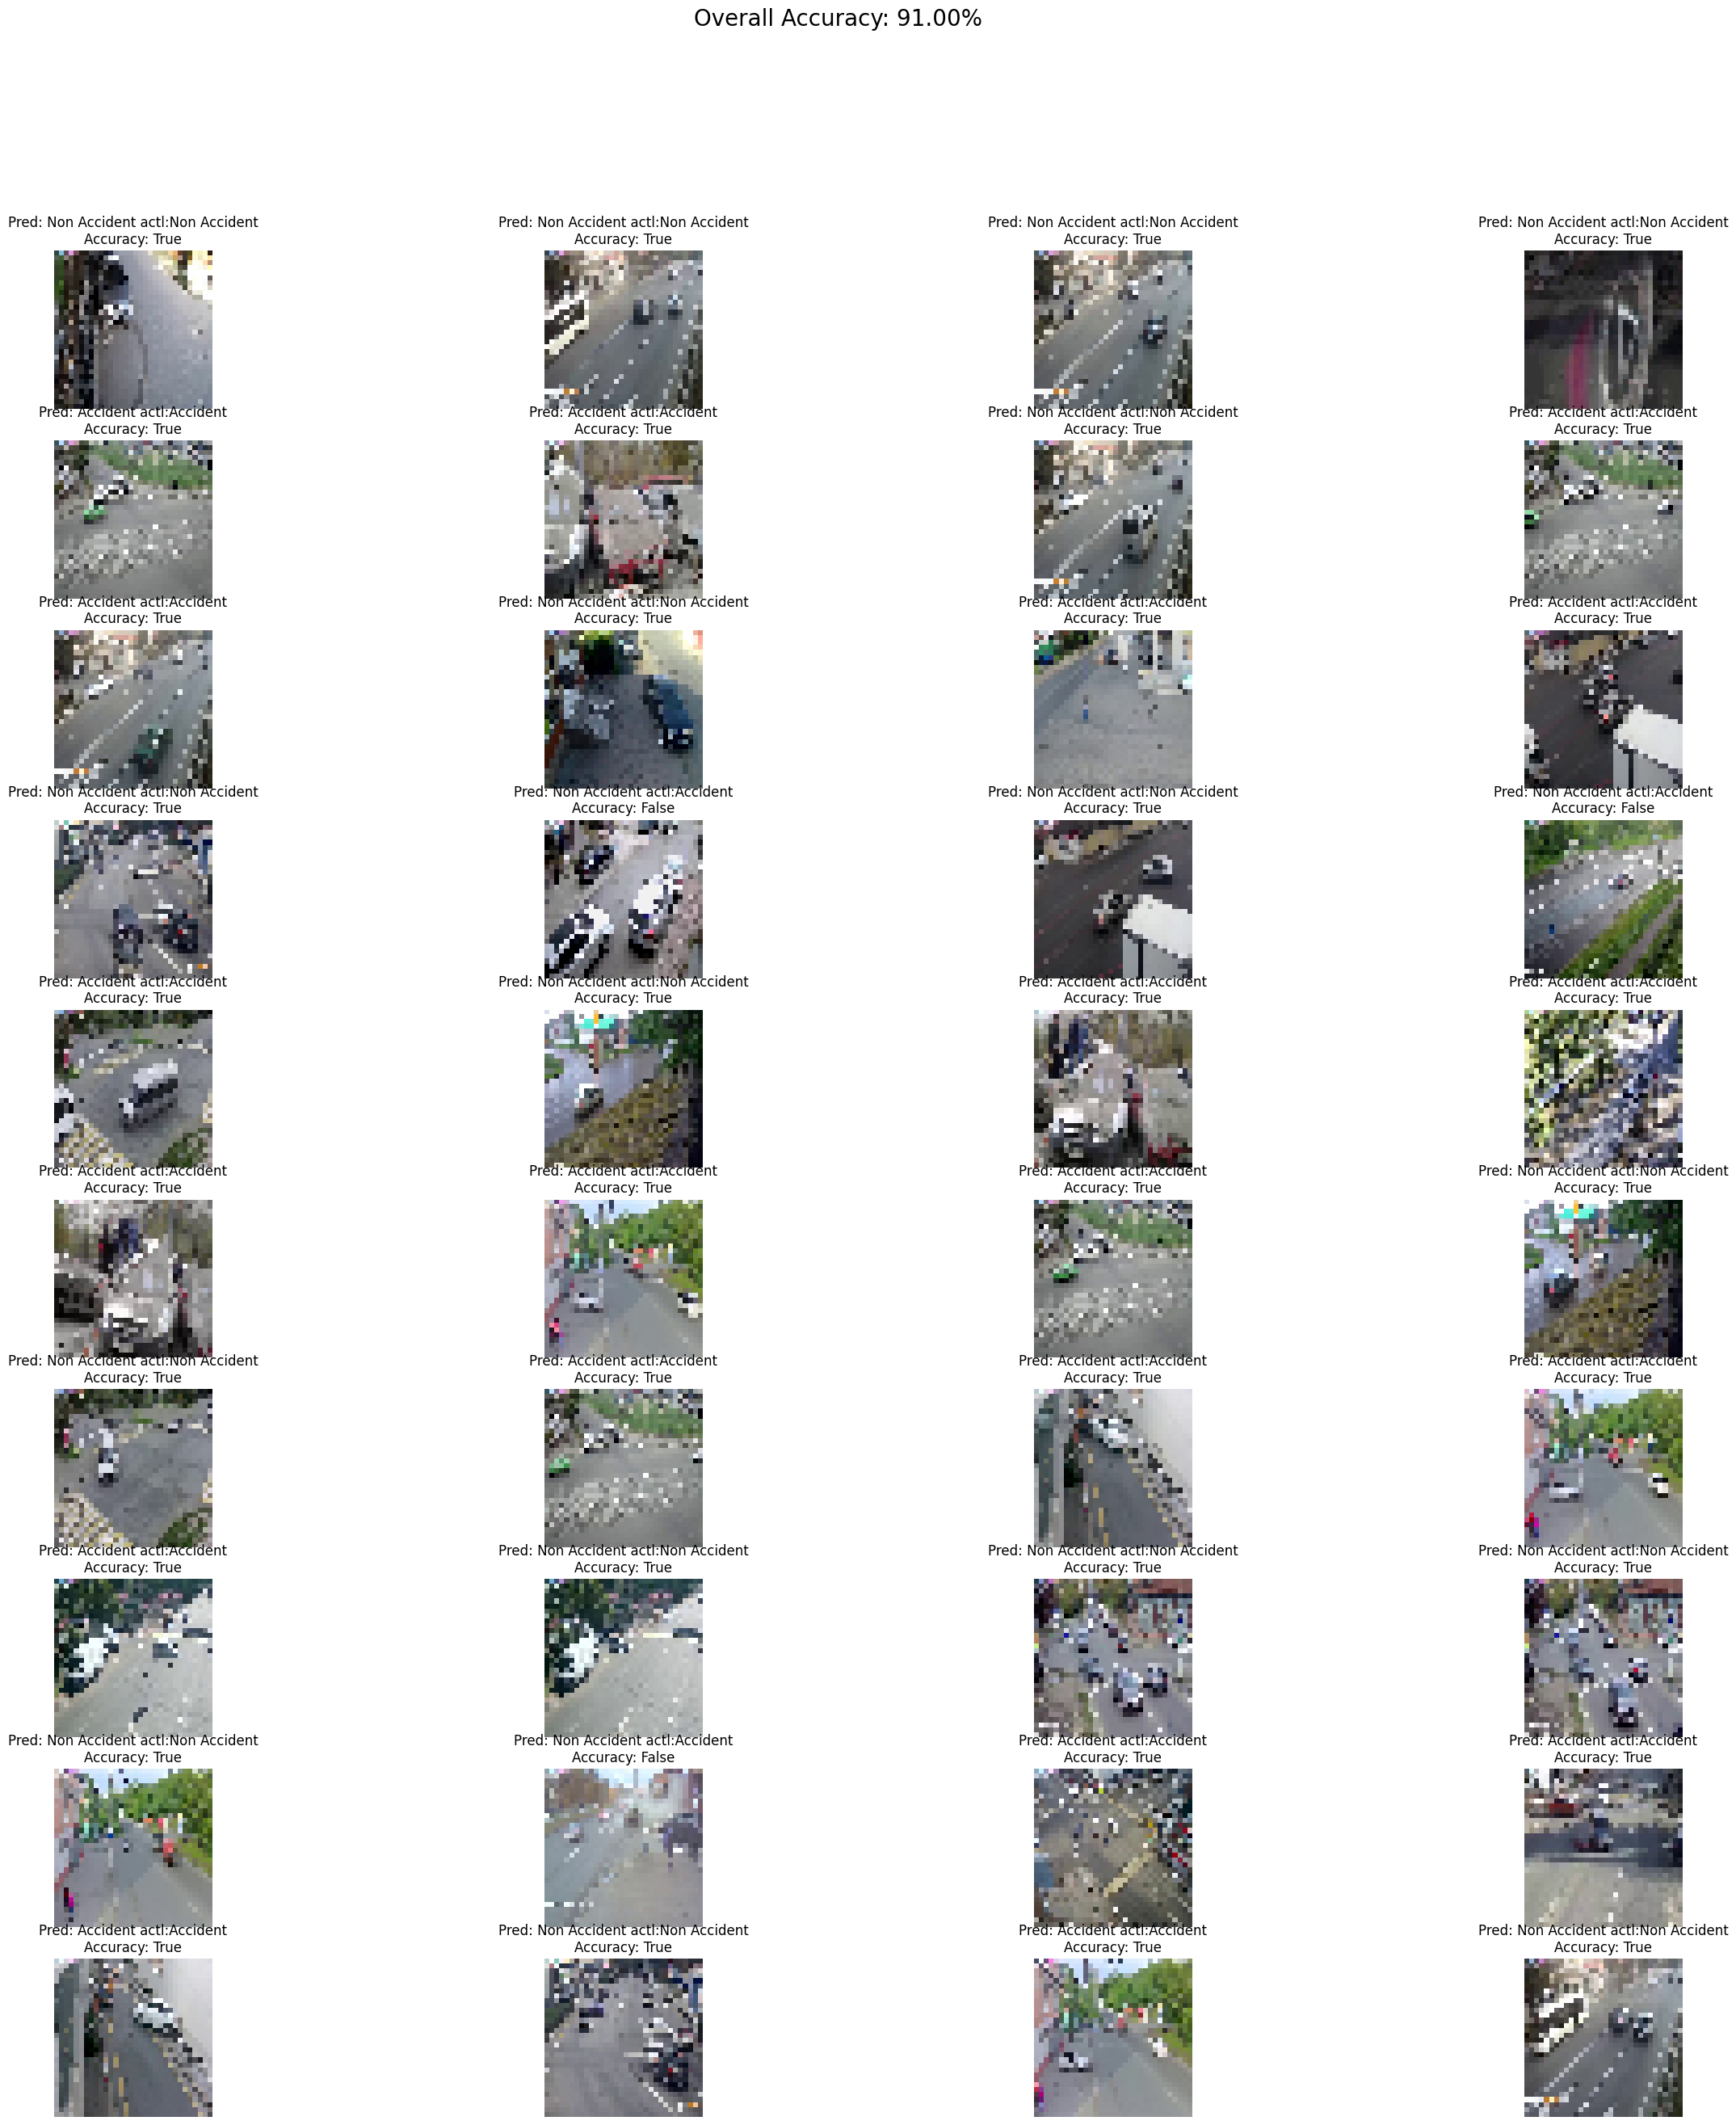

In [19]:

AccuracyVector = []

plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    
    accuracy = np.mean(AccuracyVector)
    
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] + f'\nAccuracy: {AccuracyVector[i]}')
        
        plt.axis('off')
        plt.grid(True)
plt.suptitle(f'Overall Accuracy: {accuracy:.2%}', fontsize=20)
plt.show()


In [20]:

truePositive=0
trueNegative=0
falsePositive=0
falseNegative=0
for i in range(0,100):
    if(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Accident'):
        truePositive+=1
    elif(predlabel[i]==class_names[labels[i]] and predlabel[i]=='Non Accident'):
        trueNegative+=1
    elif(predlabel[i]=='Non Accident' and class_names[labels[i]]=='Accident'):
        falseNegative+=1
    else:
        falsePositive+=1

In [22]:
print(f'True positives are: {truePositive}')
print(f'True negatives are: {trueNegative}')
print(f'False negatives are: {falseNegative}')
print(f'False positives are: {falsePositive}')

True positives are: 43
True negatives are: 48
False negatives are: 4
False positives are: 5


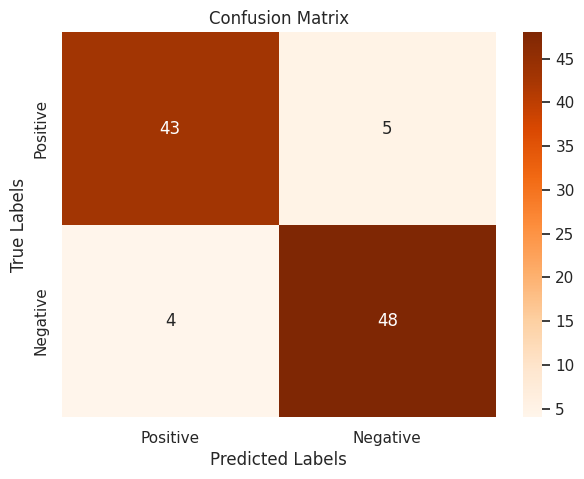

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



confusion_mat = confusion_matrix([1, 0, 1, 0], [1, 0, 0, 1],
                                  labels=[1, 0],
                                  sample_weight=[truePositive, trueNegative, falsePositive, falseNegative])

labels = ['Positive', 'Negative']

sns.set()
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

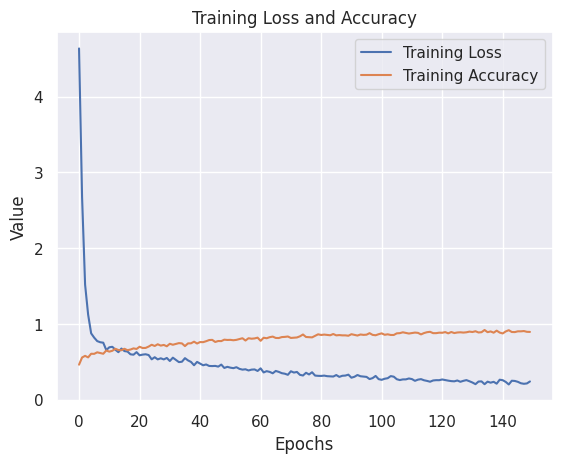

In [97]:
import matplotlib.pyplot as plt
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['Accuracy'], label='Training Accuracy') 
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

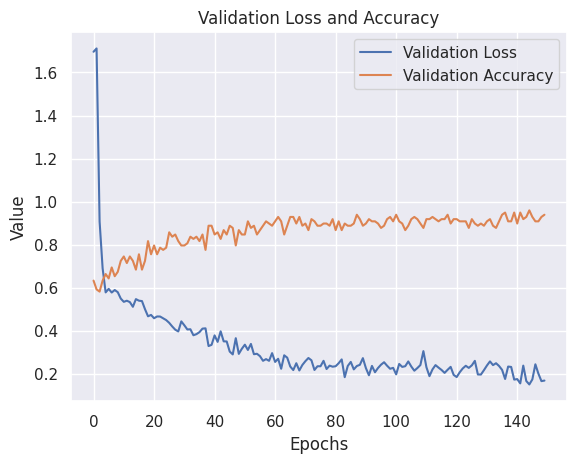

In [98]:
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.plot(results.history['val_Accuracy'], label='Validation Accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()
plt.show()

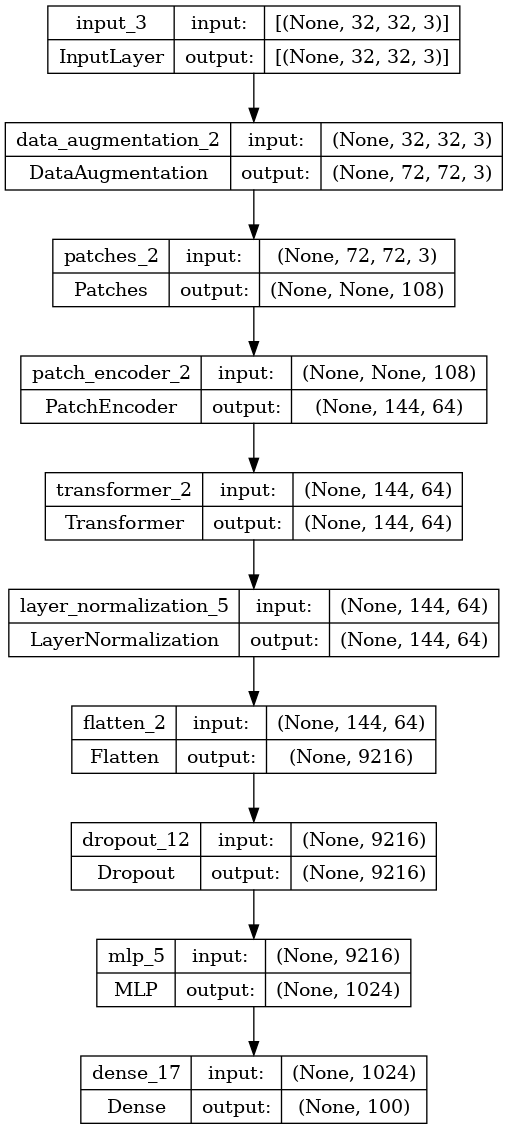

In [99]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [100]:
print(class_names)

['Accident', 'Non Accident']


In [132]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_true = []
y_pred = []

for images, labels in testing_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy()) 
    y_pred.extend(np.argmax(predictions, axis=1))  

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


4/4 [==============================] - 0s 16ms/step
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
